#semantic Segmentation of ariel images
The Semantic Drone Dataset focuses on semantic understanding of urban scenes for increasing the safety of autonomous drone flight and landing procedures. The imagery depicts more than 20 houses from nadir (bird's eye) view acquired at an altitude of 5 to 30 meters above ground. A high resolution camera was used to acquire images at a size of 6000x4000px (24Mpx). The training set contains 400 publicly available images and the test set is made up of 200 private images.

The U-Net image segmentation pipeline consists of the following steps:

1. Data Collection: Gather a dataset of images along with their corresponding ground truth segmentation masks. These images can be acquired from various sources or collected specifically for the segmentation task.

2. Data Preprocessing: Preprocess the images and masks to ensure they are in the desired format and size. Common preprocessing steps include resizing, normalization, and data augmentation techniques like rotation, scaling, and flipping to increase the dataset size and improve model generalization.

3. Dataset Split: Split the dataset into training, validation, and testing sets. The training set is used to train the U-Net model, the validation set is used to tune hyperparameters and monitor model performance, and the testing set is used to evaluate the final model's performance.

4. U-Net Model Architecture: Design the U-Net model architecture based on the task requirements. The U-Net architecture consists of an encoder (contracting path) and a decoder (expanding path), connected by skip connections to retain spatial information. The model can be modified based on the specific segmentation task and the input image dimensions.

5. Model Training: Train the U-Net model using the training set. This involves feeding the input images into the model and comparing the predicted segmentation maps with the ground truth masks using a suitable loss function, such as binary cross-entropy or dice coefficient loss. Optimize the model's parameters using an optimization algorithm like stochastic gradient descent (SGD) or Adam.

6. Model Evaluation: Evaluate the trained model's performance using the validation set. Compute evaluation metrics such as Intersection over Union (IoU), precision, recall, and F1 score to assess the accuracy and quality of the segmentation results. Adjust the model or training parameters if necessary.

7. Model Testing: Assess the U-Net model's generalization ability by applying it to the unseen testing set. Generate segmentation maps for the test images and compare them with the ground truth masks to evaluate the model's performance on new data.

8. Visualization: Visualize the input images, predicted segmentation maps, and ground truth masks to visually inspect and compare the results. This can aid in understanding the model's performance and identifying areas for improvement.

9. Documentation and Reporting: Document the pipeline steps, methodology, implementation details, and performance results to maintain a record and share insights with other researchers or stakeholders.

Importing necessary libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import io
import pandas as pd
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.__version__
import PIL
PIL.__version__
from PIL import Image
from glob import glob
import os
os.getcwd()
import cv2

import torch
torch.__version__
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
torchvision.__version__
from torchvision import transforms

In [ ]:
!pip install -U segmentation-models-pytorch
import segmentation_models_pytorch as smp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=a04308ccb3e11d0b8a2ca6e57fd6bb6c74f77b9e273e714bde3dcfdfc1c56932
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=9c76f002b09af419adefcda1fce57

Creating directory for calling teh data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib
orginal_img ='/content/drive/MyDrive/drone_images/original_images'
img_labels='/content/drive/MyDrive/drone_images/RGB_color_image_masks'
inp_list=os.listdir(orginal_img)
mask_list=os.listdir(img_labels)
inp_list.sort()
mask_list.sort()
images=[os.path.join(orginal_img,i)for i in inp_list ]
labels=[os.path.join(img_labels,i)for i in mask_list]

In [ ]:
print(labels)

['/content/drive/MyDrive/drone_images/RGB_color_image_masks/000.png', '/content/drive/MyDrive/drone_images/RGB_color_image_masks/001.png', '/content/drive/MyDrive/drone_images/RGB_color_image_masks/002.png', '/content/drive/MyDrive/drone_images/RGB_color_image_masks/003.png', '/content/drive/MyDrive/drone_images/RGB_color_image_masks/004.png', '/content/drive/MyDrive/drone_images/RGB_color_image_masks/005.png', '/content/drive/MyDrive/drone_images/RGB_color_image_masks/006.png', '/content/drive/MyDrive/drone_images/RGB_color_image_masks/008.png', '/content/drive/MyDrive/drone_images/RGB_color_image_masks/011.png', '/content/drive/MyDrive/drone_images/RGB_color_image_masks/013.png', '/content/drive/MyDrive/drone_images/RGB_color_image_masks/014.png', '/content/drive/MyDrive/drone_images/RGB_color_image_masks/015.png', '/content/drive/MyDrive/drone_images/RGB_color_image_masks/016.png', '/content/drive/MyDrive/drone_images/RGB_color_image_masks/018.png', '/content/drive/MyDrive/drone_ima

Visualizing the data

In [ ]:
color_val=pd.read_csv('/content/drive/MyDrive/drone_images/class_dict_seg.csv')

In [ ]:
def label_colors():
    '''
    This method is just to print the label and their colors for reference
    '''
    for index,label in enumerate(color_val.name):
        plt.subplot(6,4,index+1)
        (r,g,b)=color_val.iloc[index].values[1:]
        img_ = np.array([[[r,g,b],[r,g,b],[r,g,b],[r,g,b]]])
        plt.title(label)
        plt.imshow(img_)
        plt.axis('off')

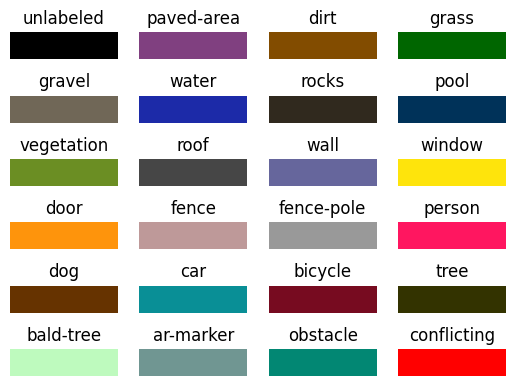

In [ ]:
label_colors()

In [ ]:
def plt_image_and_mask_with_dataset(image_ds,mask_ds):
    _,arr = plt.subplots(1,2,figsize=(10,10))
    arr[0].imshow(tf.keras.preprocessing.image.array_to_img(image_ds))
    arr[0].axis('off')
    arr[1].imshow(tf.keras.preprocessing.image.array_to_img(mask_ds))
    arr[1].axis('off')

tf.Tensor(b'/content/drive/MyDrive/drone_images/original_images/000.jpg', shape=(), dtype=string) tf.Tensor(b'/content/drive/MyDrive/drone_images/RGB_color_image_masks/000.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/drone_images/original_images/001.jpg', shape=(), dtype=string) tf.Tensor(b'/content/drive/MyDrive/drone_images/RGB_color_image_masks/001.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/drone_images/original_images/002.jpg', shape=(), dtype=string) tf.Tensor(b'/content/drive/MyDrive/drone_images/RGB_color_image_masks/002.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/drone_images/original_images/003.jpg', shape=(), dtype=string) tf.Tensor(b'/content/drive/MyDrive/drone_images/RGB_color_image_masks/003.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/drone_images/original_images/004.jpg', shape=(), dtype=string) tf.Tensor(b'/content/drive/MyDrive/drone_images/RGB_color_image_masks/004.png', shape=(), dtyp

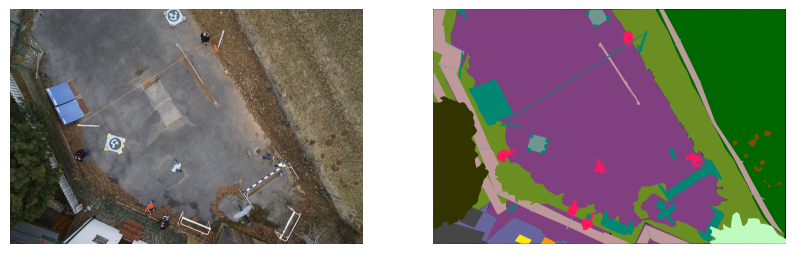

In [ ]:
image_names  = tf.constant(images)
mask_names = tf.constant(labels)

dataset = tf.data.Dataset.from_tensor_slices((image_names,mask_names))
for image,mask in dataset.take(10):
    print(image, mask)
for image,mask in dataset.take(2):
    img=tf.io.read_file(image)
    img=tf.io.decode_png(img,channels=3)

    msk=tf.io.read_file(mask)
    msk=tf.io.decode_png(msk,channels=3)

plt_image_and_mask_with_dataset(img,msk)

In [ ]:
class_list = color_val.name.values.tolist()
print(class_list)
len(class_list)

['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']


24

In [ ]:
img=sorted(glob('/content/drive/MyDrive/drone_images/original_images/*.jpg'))


#Creating the dataset class for image loading

In [ ]:
class Dataset(torch.utils.data.Dataset):

      def __init__(
          self,
          transform = None,
          classes = None,
          augmentation = None
          ):
        self.imgpath_list = sorted(glob('/content/drive/MyDrive/drone_images/original_images/*.jpg'))
        self.labelpath_list = sorted(glob('/content/drive/MyDrive/drone_images/label_images_semantic/*.png'))

      def __getitem__(self, i):

        imgpath = self.imgpath_list[i]
        img = cv2.imread(imgpath)
        img = cv2.resize(img, dsize = (128, 128))
        img = img / 255
        img = torch.from_numpy(img.astype(np.float32)).clone()
        img = img.permute(2, 0, 1)

        labelpath = self.labelpath_list[i]
        label = Image.open(labelpath)
        label = np.asarray(label)
        label = cv2.resize(label, dsize = (128, 128))
        label = torch.from_numpy(label.astype(np.float32)).clone()
        label = torch.nn.functional.one_hot(label.long(), num_classes = len(class_list))
        label = label.to(torch.float32)
        label = label.permute(2, 0, 1)

        data = {"img": img, "label": label}
        return data
b
      def __len__(self):
            return len(self.imgpath_list)

In [ ]:
dataset = Dataset()

Spliting the loaded data in train, validation and test sets and creating the data loader

In [ ]:
train, val, test = torch.utils.data.random_split(dataset = dataset, lengths = [320, 40, 40], generator = torch.Generator().manual_seed(42))

len(train), len(val), len(test)

(320, 40, 40)

In [ ]:
batch_size = 4

train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle = True, drop_last = True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

#Constructing the U-NET architecture
The U-Net model has following features:

#encoding:
 The encoding path consists of a series of convolutional and pooling layers, which progressively reduce the spatial dimensions while increasing the number of feature channels. This allows the network to capture both local and global context information.

#decoding:
 The decoding path uses transposed convolutions (also known as upsampling or deconvolution) to gradually restore the spatial resolution. Skip connections are introduced between the corresponding layers in the encoding and decoding paths. These skip connections help to preserve high-resolution features and aid in precise segmentation.

#Bottleneck:
The U-Net architecture includes a bottleneck layer, where the spatial information is compressed into a lower-dimensional representation. This compressed representation serves as a bridge between the encoding and decoding paths, enabling efficient information flow.

#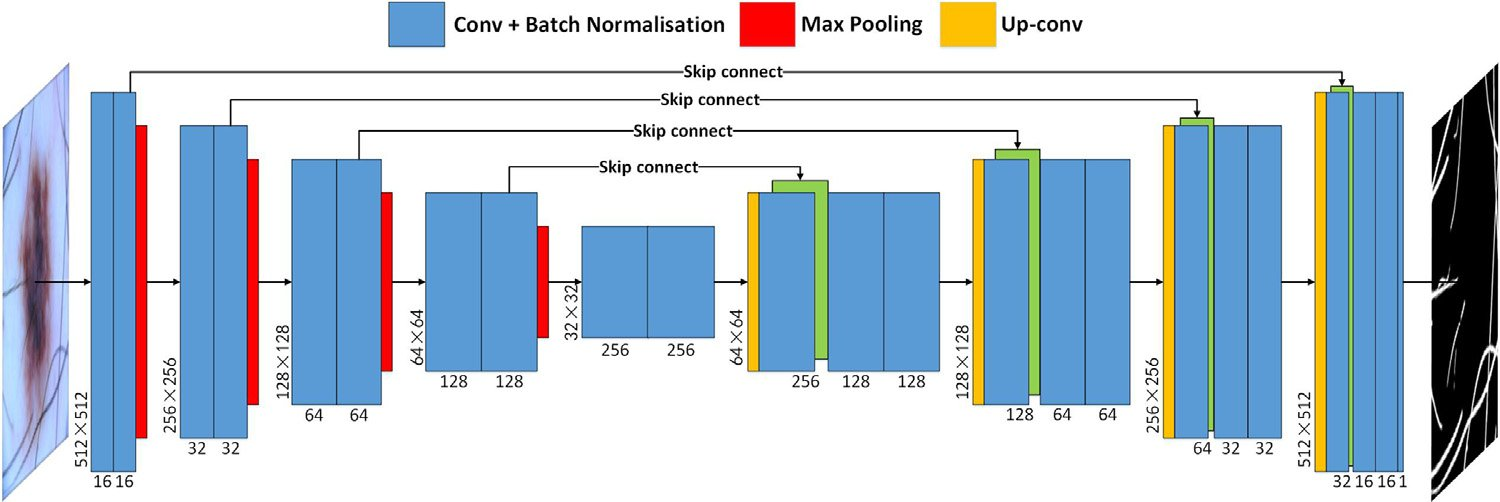Skip Connections:
 The skip connections mentioned earlier allow the network to leverage both low-level and high-level features. By combining features from different levels of abstraction, the U-Net model can achieve accurate segmentation results even for small and intricate structures.

In [ ]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size = 3, padding = "same")
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.rl = nn.ReLU()
        self.conv2 = nn.Conv2d(middle_channels, out_channels, kernel_size = 3, padding = "same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rl(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.rl(x)
        return x

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor = 2, mode = "bilinear", align_corners = True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding = "same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.TCB1 = ConvBlock(3, 64, 64)
        self.TCB2 = ConvBlock(64, 128, 128)
        self.TCB3 = ConvBlock(128, 256, 256)
        self.TCB4 = ConvBlock(256, 512, 512)
        self.TCB5 = ConvBlock(512, 1024, 1024)
        self.TCB6 = ConvBlock(1024, 512, 512)
        self.TCB7 = ConvBlock(512, 256, 256)
        self.TCB8 = ConvBlock(256, 128, 128)
        self.TCB9 = ConvBlock(128, 64, 64)
        self.maxpool = nn.MaxPool2d(2, stride = 2)

        self.UC1 = UpConv(1024, 512)
        self.UC2 = UpConv(512, 256)
        self.UC3 = UpConv(256, 128)
        self.UC4= UpConv(128, 64)

        self.conv1 = nn.Conv2d(64, 24, kernel_size = 1)
        self.soft = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.TCB1(x)
        x1 = x
        x = self.maxpool(x)

        x = self.TCB2(x)
        x2 = x
        x = self.maxpool(x)

        x = self.TCB3(x)
        x3 = x
        x = self.maxpool(x)

        x = self.TCB4(x)
        x4 = x
        x = self.maxpool(x)

        x = self.TCB5(x)

        x = self.UC1(x)
        x = torch.cat([x4, x], dim = 1)
        x = self.TCB6(x)

        x = self.UC2(x)
        x = torch.cat([x3, x], dim = 1)
        x = self.TCB7(x)

        x = self.UC3(x)
        x = torch.cat([x2, x], dim = 1)
        x = self.TCB8(x)

        x = self.UC4(x)
        x = torch.cat([x1, x], dim = 1)
        x = self.TCB9(x)

        x = self.conv1(x)

        return x

#Initializing the adam optimizer and crossentropy loss and Tverskyloss as criterion
TverskyLoss-

Loss function: Tversky Loss
Mode: 'multilabel' (used for multi-label segmentation tasks)
Log loss: False (disables the logarithmic transformation of the loss)

Soft BCE with Logits Loss-

Purpose: This loss function is commonly used for binary classification tasks where the model outputs logits (raw predicted values) rather than probabilities.
Functionality: It combines a sigmoid activation function (applied internally) with the binary cross-entropy loss. The sigmoid activation function squashes the logits into the range [0, 1], allowing them to be interpreted as probabilities.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = UNet().to(device)
optimizer = optim.Adam(unet.parameters(), lr = 0.001)

In [ ]:
TverskyLoss = smp.losses.TverskyLoss(mode = 'multilabel', log_loss = False)
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
def criterion(pred,target):
    return 0.5 * BCELoss(pred, target) + 0.5 * TverskyLoss(pred, target)

#Training and validating the model

In [ ]:
history = {"train_loss": []}
n = 0
m = 0
val_loss_min = np.Inf
validation_accuracy = []
validation_loss = []

for epoch in range(20):
  train_accuracy = 0
  train_loss = 0
  val_accuracy = 0
  val_loss = 0
  correct_pixels = 0
  total_pixels = 0

# training
  unet.train()
  for i, data in enumerate(train_loader):
    inputs, labels = data["img"].to(device), data["label"].to(device)
    optimizer.zero_grad()
    outputs = unet(inputs)

    # pixel accuracy
    thresholded_outputs = (outputs > 0.5).int()
    correct_pixels = (thresholded_outputs== labels).sum().item()
    total_pixels += (inputs.size(2) * inputs.size(3)) * inputs.size(0)
    train_acc = correct_pixels / total_pixels
    train_accuracy += train_acc

    # loss
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    history["train_loss"].append(loss.item())
    n += 1
    if i % ((len(train) // batch_size) // 10) == (len(train) // batch_size) // 10 - 1:
      print(f"epoch:{epoch + 1}  index:{i + 1}  train_accuracy:{train_accuracy / n:.5f}")
      print(f"epoch:{epoch + 1}  index:{i + 1}  train_loss:{train_loss / n:.5f}")
      n = 0
      train_accuracy = 0
      train_loss = 0

# validation
  unet.eval()
  with torch.no_grad():
    for i, data in enumerate(val_loader):
      inputs, labels = data["img"].to(device), data["label"].to(device)
      outputs = unet(inputs)

      # pixel accuracy
      thresholded_outputs = (outputs > 0.5).int()
      correct_pixels = (thresholded_outputs == labels).sum().item()
      total_pixels += (inputs.size(2) * inputs.size(3)) * inputs.size(0)
      val_acc = correct_pixels / total_pixels
      val_accuracy += val_acc

      # loss
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      m += 1
      if i % (len(val) // batch_size) == len(val) // batch_size - 1:
        print(f"epoch:{epoch + 1}  index:{i + 1}  validation_accuracy:{val_accuracy / m:.5f}")
        print(f"epoch:{epoch + 1}  index:{i + 1}  validation_loss:{val_loss / m:.5f}")
        validation_accuracy.append(val_accuracy)
        validation_loss.append(val_loss)
        if val_loss < val_loss_min:
            val_loss_min = val_loss
            torch.save(unet.state_dict(), 'semantic_segmentation.pt')
            print('Detected network improvement, saving current model')

        m = 0
        val_accuracy = 0
        val_loss = 0

print("finish training")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


epoch:1  index:8  train_accuracy:7.41327
epoch:1  index:8  train_loss:0.76035
epoch:1  index:16  train_accuracy:1.90760
epoch:1  index:16  train_loss:0.70405
epoch:1  index:24  train_accuracy:1.14368
epoch:1  index:24  train_loss:0.65454
epoch:1  index:32  train_accuracy:0.81624
epoch:1  index:32  train_loss:0.62768
epoch:1  index:40  train_accuracy:0.63830
epoch:1  index:40  train_loss:0.59344
epoch:1  index:48  train_accuracy:0.52200
epoch:1  index:48  train_loss:0.57800
epoch:1  index:56  train_accuracy:0.44370
epoch:1  index:56  train_loss:0.54742
epoch:1  index:64  train_accuracy:0.38441
epoch:1  index:64  train_loss:0.53846
epoch:1  index:72  train_accuracy:0.33985
epoch:1  index:72  train_loss:0.52110
epoch:1  index:80  train_accuracy:0.30258
epoch:1  index:80  train_loss:0.53366
epoch:1  index:10  validation_accuracy:0.27088
epoch:1  index:10  validation_loss:0.54542
Detected network improvement, saving current model
epoch:2  index:8  train_accuracy:7.86487
epoch:2  index:8  tr

Visualizing the training loss and validation accuracy

Text(0, 0.5, 'loss')

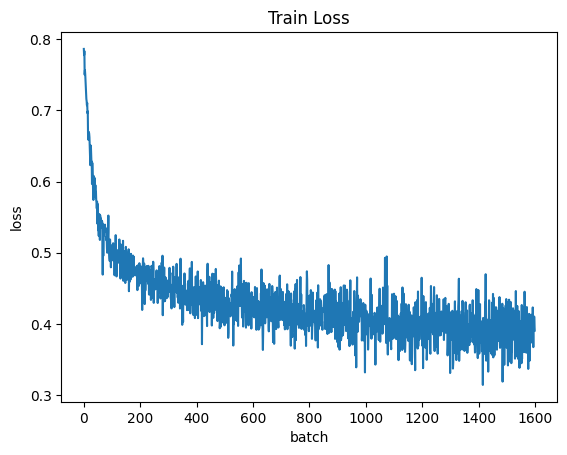

In [ ]:

plt.title("Train Loss")
plt.plot(history["train_loss"])
plt.xlabel('batch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

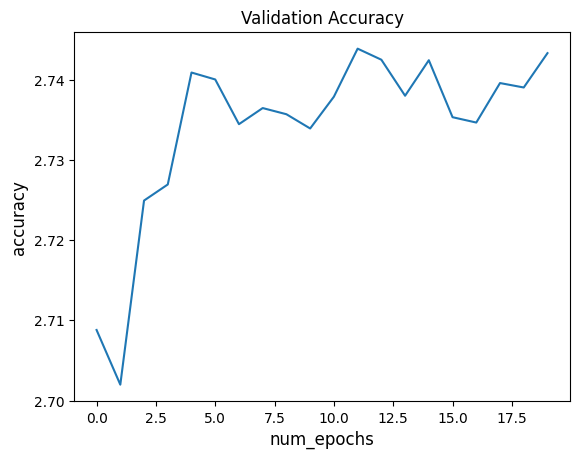

In [ ]:
plt.title("Validation Accuracy")
plt.plot(validation_accuracy)
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('accuracy', fontsize = 12)

#Testing the model

In [ ]:
model = UNet()
model.load_state_dict(torch.load(r"/content/drive/MyDrive/drone_images/semantic_segmentation.pt"))
model.eval()
with torch.no_grad():
  data = next(iter(test_loader))
  inputs, labels = data["img"], data["label"]
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  print("Loss: ", loss.item())

  thresholded_outputs = (outputs > 0.5).int()
  intersection = torch.logical_and(thresholded_outputs, labels).sum(dim = [1, 2, 3]).float()
  union = torch.logical_or(thresholded_outputs, labels).sum(dim = [1, 2, 3]).float()
  iou_score = (intersection / union).mean().item()
  print("Intersection over Union:", iou_score)


sigmoid = nn.Sigmoid()
outputs = sigmoid(outputs)
pred = torch.argmax(outputs, axis = 1)
pred = torch.nn.functional.one_hot(pred.long(), num_classes = len(class_list)).to(torch.float32)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


Loss:  0.38545772433280945
Intersection over Union: 0.4722510576248169


#Visualizing the prediction

(-0.5, 127.5, 127.5, -0.5)

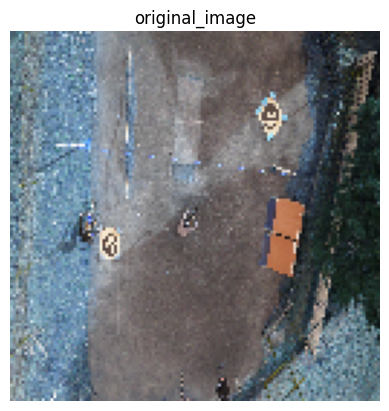

In [ ]:
plt.figure()
plt.imshow(data["img"][1, :, :, :].permute(1, 2, 0))
plt.title("original_image")
plt.axis("off")

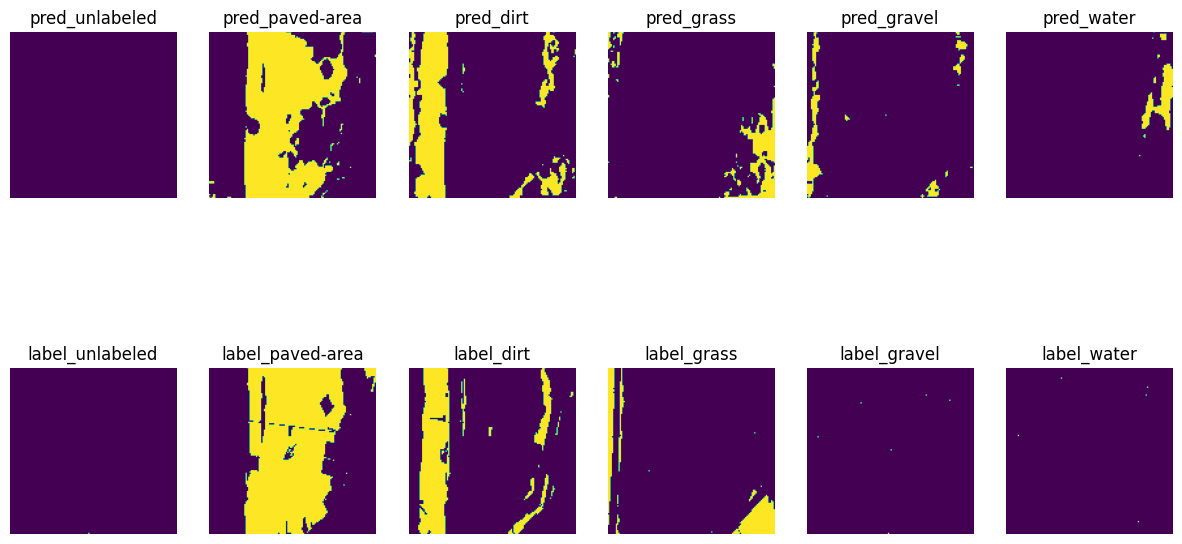

In [ ]:
classes = class_list
fig, ax = plt.subplots(2, 6, figsize = (15, 8))
for i in range(2):
    for j, cl in enumerate(classes):
        if i == 0 and j < 6:
            ax[i, j].imshow(pred[1, :, :, j])
            ax[i, j].set_title(f"pred_{cl}")
            ax[i, j].axis("off")
        elif j < 6:
            ax[i, j].imshow(data["label"][1, j, :, :])
            ax[i, j].set_title(f"label_{cl}")
            ax[i, j].axis("off")


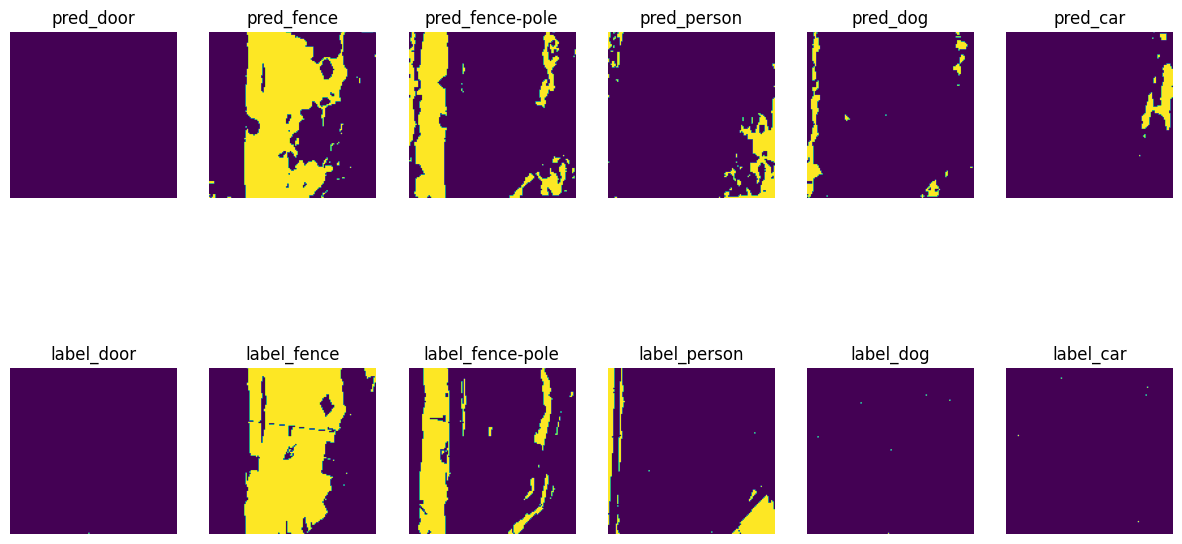

In [ ]:
classes = class_list
fig, ax = plt.subplots(2, 6, figsize = (15, 8))
for i in range(2):
    for j, cl in enumerate(classes[12:18]):
        if i == 0 and j < 6:
            ax[i, j].imshow(pred[1, :, :, j])
            ax[i, j].set_title(f"pred_{cl}")
            ax[i, j].axis("off")
        elif j < 6:
            ax[i, j].imshow(data["label"][1, j, :, :])
            ax[i, j].set_title(f"label_{cl}")
            ax[i, j].axis("off")

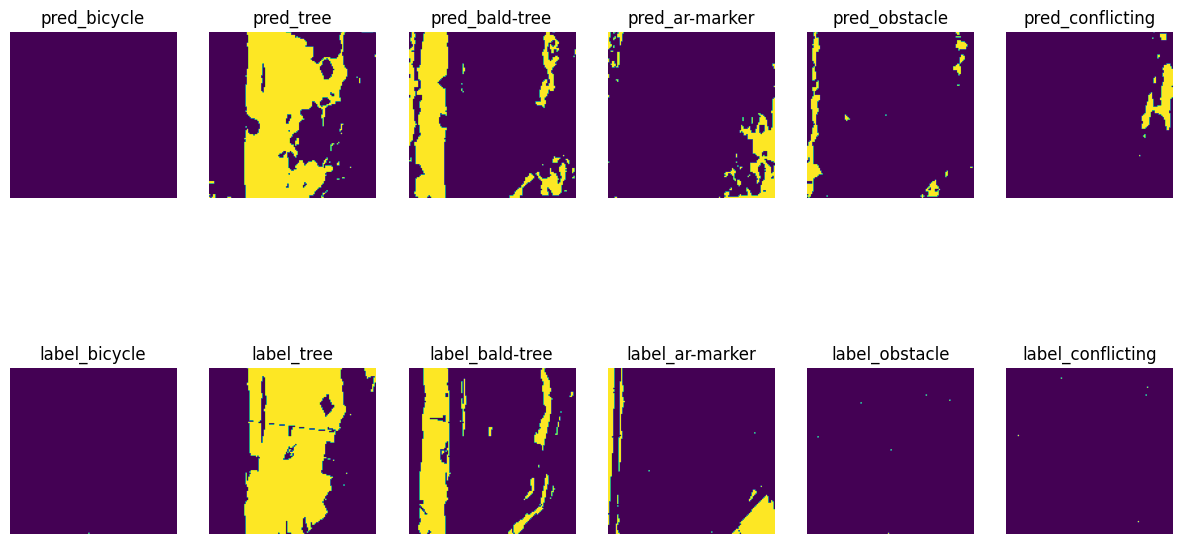

In [ ]:
classes = class_list
fig, ax = plt.subplots(2, 6, figsize = (15, 8))
for i in range(2):
    for j, cl in enumerate(classes[18:]):
        if i == 0 and j < 6:
            ax[i, j].imshow(pred[1, :, :, j])
            ax[i, j].set_title(f"pred_{cl}")
            ax[i, j].axis("off")
        elif j < 6:
            ax[i, j].imshow(data["label"][1, j, :, :])
            ax[i, j].set_title(f"label_{cl}")
            ax[i, j].axis("off")

#Streamlit Dashboard

In [ ]:
! pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
%%writefile streamlit_app.py
import streamlit as st
import segmentation_models_pytorch as smp
import imageio
import pandas as pd
import tempfile
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import io
from PIL import Image
global data
color_val=pd.read_csv('/content/drive/MyDrive/drone_images/class_dict_seg.csv')
class_list = color_val.name.values.tolist()
TverskyLoss = smp.losses.TverskyLoss(mode = 'multilabel', log_loss = False)
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
def criterion(pred,target):
    return 0.5 * BCELoss(pred, target) + 0.5 * TverskyLoss(pred, target)
def predict(datas,truth):

    class ConvBlock(nn.Module):
        def __init__(self, in_channels, middle_channels, out_channels):
            super().__init__()
            self.conv1 = nn.Conv2d(in_channels, middle_channels, kernel_size = 3, padding = "same")
            self.bn1 = nn.BatchNorm2d(middle_channels)
            self.rl = nn.ReLU()
            self.conv2 = nn.Conv2d(middle_channels, out_channels, kernel_size = 3, padding = "same")
            self.bn2 = nn.BatchNorm2d(out_channels)

        def forward(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.rl(x)
            x = self.conv2(x)
            x = self.bn2(x)
            x = self.rl(x)
            return x

    class UpConv(nn.Module):
        def __init__(self, in_channels, out_channels):
            super().__init__()
            self.up = nn.Upsample(scale_factor = 2, mode = "bilinear", align_corners = True)
            self.bn1 = nn.BatchNorm2d(in_channels)
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding = "same")
            self.bn2 = nn.BatchNorm2d(out_channels)

        def forward(self, x):
            x = self.up(x)
            x = self.bn1(x)
            x = self.conv(x)
            x = self.bn2(x)
            return x

    class UNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.TCB1 = ConvBlock(3, 64, 64)
            self.TCB2 = ConvBlock(64, 128, 128)
            self.TCB3 = ConvBlock(128, 256, 256)
            self.TCB4 = ConvBlock(256, 512, 512)
            self.TCB5 = ConvBlock(512, 1024, 1024)
            self.TCB6 = ConvBlock(1024, 512, 512)
            self.TCB7 = ConvBlock(512, 256, 256)
            self.TCB8 = ConvBlock(256, 128, 128)
            self.TCB9 = ConvBlock(128, 64, 64)
            self.maxpool = nn.MaxPool2d(2, stride = 2)

            self.UC1 = UpConv(1024, 512)
            self.UC2 = UpConv(512, 256)
            self.UC3 = UpConv(256, 128)
            self.UC4= UpConv(128, 64)

            self.conv1 = nn.Conv2d(64, 24, kernel_size = 1)
            self.soft = nn.Softmax(dim = 1)

        def forward(self, x):
            x = self.TCB1(x)
            x1 = x
            x = self.maxpool(x)

            x = self.TCB2(x)
            x2 = x
            x = self.maxpool(x)

            x = self.TCB3(x)
            x3 = x
            x = self.maxpool(x)

            x = self.TCB4(x)
            x4 = x
            x = self.maxpool(x)

            x = self.TCB5(x)

            x = self.UC1(x)
            x = torch.cat([x4, x], dim = 1)
            x = self.TCB6(x)

            x = self.UC2(x)
            x = torch.cat([x3, x], dim = 1)
            x = self.TCB7(x)

            x = self.UC3(x)
            x = torch.cat([x2, x], dim = 1)
            x = self.TCB8(x)

            x = self.UC4(x)
            x = torch.cat([x1, x], dim = 1)
            x = self.TCB9(x)

            x = self.conv1(x)

            return x


    global data
    class Dataset(torch.utils.data.Dataset):

      def __init__(
          self,
          transform = None,
          classes = None,
          augmentation = None
          ):
        self.imgpath_list = datas
        self.labelpath_list = truth

      def __getitem__(self,i):

        imgpath = self.imgpath_list
        img = cv2.imread(imgpath)
        img = cv2.resize(img, dsize = (128, 128))
        img = img / 255
        img = torch.from_numpy(img.astype(np.float32)).clone()
        img = img.permute(2, 0, 1)

        labelpath = self.labelpath_list
        label = Image.open(labelpath)
        label = np.asarray(label)
        label = cv2.resize(label, dsize = (128, 128))
        label = torch.from_numpy(label.astype(np.float32)).clone()
        label = torch.nn.functional.one_hot(label.long(), num_classes = len(class_list))
        label = label.to(torch.float32)
        label = label.permute(2, 0, 1)
        data = {"img": img, "label": label}
        return data

      def __len__(self):
         return len(self.imgpath_list)
    global outputs
    dataset = Dataset()
    test_loader = torch.utils.data.DataLoader(dataset)

    model = UNet()
    model.load_state_dict(torch.load("/content/drive/MyDrive/drone_images/semantic_segmentation.pt"))
    model.eval()
    with torch.no_grad():
        data = next(iter(test_loader))
        inputs, labels = data['img'],data['label']
        outputs = model(inputs)
        loss = criterion(outputs, labels)


        thresholded_outputs = (outputs > 0.5).int()
        intersection = torch.logical_and(thresholded_outputs, labels).sum(dim = [1, 2, 3]).float()
        union = torch.logical_or(thresholded_outputs, labels).sum(dim = [1, 2, 3]).float()
        iou_score = (intersection / union).mean().item()
        #print("Intersection over Union:", iou_score)
        return loss,iou_score
        sigmoid = nn.Sigmoid()
        outputs = sigmoid(outputs)


def plot():
    pred = torch.argmax(outputs, axis = 1)
    pred = torch.nn.functional.one_hot(pred.long(), num_classes = len(class_list)).to(torch.float32)


    classes = class_list
    fig, ax = plt.subplots(2, 6, figsize = (15, 8))
    for i in range(2):
        for j, cl in enumerate(classes):
            if i == 0 and j < 6:
                ax[i, j].imshow(pred[0, :, :, j])
                ax[i, j].set_title(f"pred_{cl}")
                ax[i, j].axis("off")
            elif j < 6:
                ax[i, j].imshow(data["label"][0, j, :, :])
                ax[i, j].set_title(f"label_{cl}")
                ax[i, j].axis("off")
    plt.tight_layout()
    st.pyplot(fig)
    fig, ax = plt.subplots(2, 6, figsize = (15, 8))
    for i in range(2):
        for j, cl in enumerate(classes[12:18]):
            if i == 0 and j < 6:
                ax[i, j].imshow(pred[0, :, :, j])
                ax[i, j].set_title(f"pred_{cl}")
                ax[i, j].axis("off")
            elif j < 6:
                ax[i, j].imshow(data["label"][0, j, :, :])
                ax[i, j].set_title(f"label_{cl}")
                ax[i, j].axis("off")
    plt.tight_layout()
    st.pyplot(fig)
    fig, ax = plt.subplots(2, 6, figsize = (15, 8))
    for i in range(2):
        for j, cl in enumerate(classes[18:24]):
            if i == 0 and j < 6:
                ax[i, j].imshow(pred[0, :, :, j])
                ax[i, j].set_title(f"pred_{cl}")
                ax[i, j].axis("off")
            elif j < 6:
                ax[i, j].imshow(data["label"][0, j, :, :])
                ax[i, j].set_title(f"label_{cl}")
                ax[i, j].axis("off")
    plt.tight_layout()
    st.pyplot(fig)
def main():

    # Streamlit app layout
    st.title("Ariel Image Segmentation")
    file1 = st.file_uploader("Upload Image File")
    file2 = st.file_uploader("Upload Mask File ")
    if file1 is not None and file2 is not None:
     file_path1 = "/content/image.jpg"
     file_path2 = "/content/mask.png"   # Replace with the desired file path
     with open(file_path1, "wb") as f:
        f.write(file1.read())
     st.success("Image saved successfully!")
     with open(file_path2, "wb") as f:
        f.write(file2.read())
     st.success("mask saved successfully!")
    try:
     if st.button("Process"):
        if file_path1 is not None and file_path2 is not None:
            a,b=predict(file_path1,file_path2)
            st.write('loss:',a)
            st.write('IOU:',b)
            st.image(file_path1)
            st.image(plot())
        else:
            st.warning("Please upload both files.")
    except:
     pass

if __name__ == '__main__':
    main()


Writing streamlit_app.py


In [ ]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 29.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=ad693031ffc1f9dfb0b2f88867a10c3888c1608b361d25979940724d144f8891
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [ ]:
!./ngrok authtokens 2RQ8knjIv53shBDjFt85gizlBFP_5sUohZJN4Sam1FQ6X6WHx

/bin/bash: ./ngrok: No such file or directory


In [ ]:
!streamlit run /content/streamlit_app.py & npx localtunnel --port 8501

[##................] / fetchMetadata: sill resolveWithNewModule ms@2.1.2 checki

npx: installed 22 in 6.98s
your url is: https://curly-files-shake.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.245.132.206:8501

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


#conclusion

#The insight from the project is that, U-net is the best in image segmentation
# (state of the art)and the model can be improved by proving a big dataset and increasing the number of epochs and various hyperparameter tuning methods.